In [8]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from rank_bm25 import BM25Okapi

k_list = [1, 2, 5, 10]

# Prepare data

In [4]:
df = pd.read_csv("gen_qa_11March.csv")
df = df[df["content"].apply(len) > 100]
df = df[df["a"] != "no question"]
print(df.shape)

(1514, 6)


In [5]:
pq_df = df.groupby("q")[["content"]].agg(set).reset_index()
query_list = pq_df["q"].unique().tolist()
passage_list = df["content"].unique().tolist()
passage2id = {p: i for i, p in enumerate(passage_list)}
id2passage = {i: p for i, p in enumerate(passage_list)}
print(f"Total queries: {len(query_list)}")
print(f"Total passages: {len(passage_list)}")

Total queries: 1499
Total passages: 1514


# Sparse Retriever (BM25)

In [22]:
tokenized_passages = [p.split(" ") for p in passage_list]

bm25_model = BM25Okapi(tokenized_passages)

In [23]:
for k in k_list:
    recall_ = []
    for idx, row in tqdm(pq_df.iterrows(), total=df.shape[0]):
        n_correct = 0
        label = row["content"]
        query = row["q"]
        top_passages = bm25_model.get_top_n(query.split(" "), passage_list, n=k)
        for p in top_passages:
            if p in label:
                n_correct += 1
        recall_.append(n_correct / min(k, len(label)))
    print(f"Recall_{k}: {np.mean(recall_):.3f}")

  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_1: 0.490


  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_2: 0.577


  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_5: 0.694


  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_10: 0.767


# Dense Retriever

In [6]:
model_name = "intfloat/e5-base-v2"
model = SentenceTransformer(
    model_name, prompts={"query": "query: ", "passage": "passage: "}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [7]:
passage_embeddings = model.encode(
    passage_list, normalize_embeddings=True, show_progress_bar=True, batch_size=64
)
query_embeddings = model.encode(
    query_list, normalize_embeddings=True, show_progress_bar=True, batch_size=64
)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [10]:
hits = util.semantic_search(query_embeddings, passage_embeddings, top_k=max(k_list))

In [13]:
for k in k_list:
    recall_ = []
    for idx, row in tqdm(pq_df.iterrows(), total=df.shape[0]):
        n_correct = 0
        label = row["content"]
        query = row["q"]
        top_passages = [id2passage[hit["corpus_id"]] for hit in hits[idx][:k]]
        for p in top_passages:
            if p in label:
                n_correct += 1
        recall_.append(n_correct / min(k, len(label)))
    print(f"Recall_{k}: {np.mean(recall_):.3f}")

  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_1: 0.510


  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_2: 0.641


  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_5: 0.770


  0%|          | 0/1514 [00:00<?, ?it/s]

Recall_10: 0.848


# Hybrid search

In [17]:
dense_score = util.cos_sim(query_embeddings, passage_embeddings).numpy()
dense_rank = (-dense_score).argsort().argsort()

In [39]:
ranking_scores = []

for idx, row in tqdm(pq_df.iterrows(), total=df.shape[0]):
    query = row["q"]
    ranking_scores.append(bm25_model.get_scores(query.split(" ")))
bm25_rank = (-np.array(ranking_scores)).argsort().argsort()

  0%|          | 0/1514 [00:00<?, ?it/s]

In [41]:
w_list = np.arange(0, 1.1, 0.1)
c_list = np.arange(10, 100, 10)
k = 5

result = {
    "weight": [],
    "c": [],
    f"recall_{k}": [],
}

for c in tqdm(c_list):
    for w in w_list:
        total_score = w * (1 / (c + dense_rank)) + (1 - w) * (1 / (c + bm25_rank))
        recall_ = []
        for idx, row in pq_df.iterrows():
            n_correct = 0
            label = row["content"]
            query = row["q"]
            score = total_score[idx]
            top_ids = np.argsort(score)[::-1][:k]
            top_passages = [id2passage[id] for id in top_ids]
            for p in top_passages:
                if p in label:
                    n_correct += 1
            recall_.append(n_correct / min(k, len(label)))
        result["weight"].append(w)
        result["c"].append(c)
        result[f"recall_{k}"].append(np.mean(recall_))

  0%|          | 0/9 [00:00<?, ?it/s]

In [43]:
result = pd.DataFrame(result)

In [58]:
result.sort_values(f"recall_{k}", ascending=False)

,weight,c,recall_5
6,0.6,10,0.828219
17,0.6,20,0.824216
5,0.5,10,0.823549
29,0.7,30,0.821681
18,0.7,20,0.819013
...,...,...,...
44,0.0,50,0.694129
11,0.0,20,0.694129
66,0.0,70,0.694129
55,0.0,60,0.694129


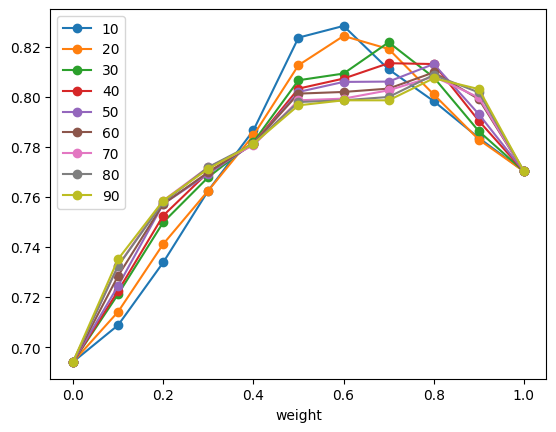

In [54]:
fig, ax = plt.subplots()
result.groupby("c").plot(x="weight", y=f"recall_{k}", marker="o", ax=ax)
ax.legend(c_list)

In [ ]:
w = 0.6
c = 10
for k in k_list:
    total_score = w * (1 / (c + dense_rank)) + (1 - w) * (1 / (c + bm25_rank))
    recall_ = []
    for idx, row in pq_df.iterrows():
        n_correct = 0
        label = row["content"]
        query = row["q"]
        score = total_score[idx]
        top_ids = np.argsort(score)[::-1][:k]
        top_passages = [id2passage[id] for id in top_ids]
        for p in top_passages:
            if p in label:
                n_correct += 1
        recall_.append(n_correct / min(k, len(label)))
    print(f"Recall_{k}: {np.mean(recall_):.3f}")